## Aluminium vacancy formation energy

Calculate the vacancy formation energy of aluminium as

$$F_\text{form} = F_\text{vac}(N-1) + \frac{N-1}{N}F_\text{perf}(N)\,.$$

$F_\text{vac}(N-1)$ is the free energy of $N-1$ atom vacancy supercell, $F_\text{perf}(N)$ the $N$ atom perfect supercell. In each instance, the free energy is $U_0 + F_\text{el} + F_\text{ph}$, where $U_0$ is the crystal internal energy, $F_\text{el}$ is the electronic free energy and $F_\text{ph}$ is the harmonic phonon free energy.

In [8]:
#Import python libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.interpolate
from scipy.integrate import simps

In [9]:
#Units and constants
rydberg_to_eV = 13.6056980659
kelvin_to_eV = 8.617333262145*10**-5 #ie Boltzmann constant, k_B, in eV/K
kelvin_to_meV = 1000*kelvin_to_eV
THz_to_meV = 1/0.24179893

### $U_0$ vacancy formation energy

In [43]:
#2x2x2 Al quantum-espresso DFT U0 energies
U0_vac = -1224.52625704
U0_perf = -1264.07264736

#Number of atoms in cells
n_vac_cell_atoms = 31
n_perf_cell_atoms = 32
n_perf_unitcell_atoms = 4

#Al vac formation energy
E0_vac_form = U0_vac - (n_vac_cell_atoms/n_perf_cell_atoms)*U0_perf
E0_vac_form = E0_vac_form*rydberg_to_eV 
E0_vac_form

0.6002846231800417

### $F_\text{el}$ contribution to Al vacancy formation energy

In [11]:
#Import data
energy_dos_perf=np.loadtxt('06_al_222_perfect_el_dos/dos_shifted.dat')
energy_dos_vac=np.loadtxt('05_al_222_vac_relaxed_scf_el_dos/dos_shifted.dat')

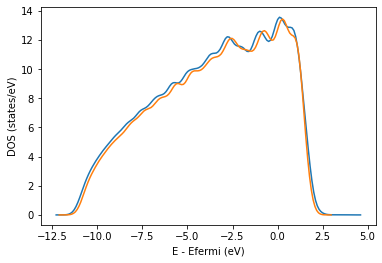

In [42]:
#Separate DOS(E) into DOS and E
dos_perf=energy_dos_perf.T[1]
energy_perf=energy_dos_perf.T[0]

dos_vac=energy_dos_vac.T[1]
energy_vac=energy_dos_vac.T[0]

plt.plot(energy_perf,dos_perf)
plt.plot(energy_vac,dos_vac)
plt.xlabel("E - Efermi (eV)")
plt.ylabel("DOS (states/eV)")
#plt.xlim(-0.1,0.1)
plt.show()




#### Sommerfeld approximation

$$ F^\text{Som}_\text{el} = -\frac{\pi^2}{6}{k_\text{B}}^2T^2g(\varepsilon_\text{F}) + O(T^4)\,.$$

In [15]:
def sommerfeld_approx_in_eV(energy,dos,T_kelvin):
    # Select the Fermi energy index, where e-ef = 0
    fermi_level_energy_index = np.where(abs(energy)==min(abs(energy)))
    #Use this index to get the density of states at the Fermi level and find S_el
    entropy = dos[fermi_level_energy_index]*((np.pi)**2)*(1/6)*T_kelvin**2*kelvin_to_eV**2
    fel = dos[fermi_level_energy_index]*((np.pi)**2)*(1/6)*T_kelvin**2*kelvin_to_eV**2
    return fel[0]

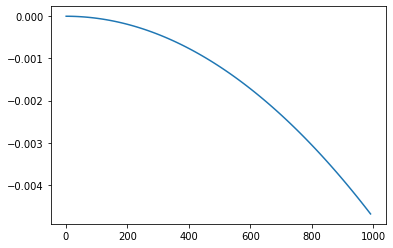

In [16]:
sommerfeld_approx_in_eV(energy_vac,dos_vac,300)
sommerfeld_approx_in_eV(energy_perf,dos_perf,300)

t_fel_difference = np.array([(T, sommerfeld_approx_in_eV(energy_vac,dos_vac,T) 
           - (n_vac_cell_atoms/n_perf_cell_atoms)*
                              sommerfeld_approx_in_eV(energy_perf,dos_perf,T)) 
                             for T in range(1,1000, 10)])

plt.plot(*t_fel_difference.T)

### $F_\text{ph}$ contirbution to vacancy formation energy

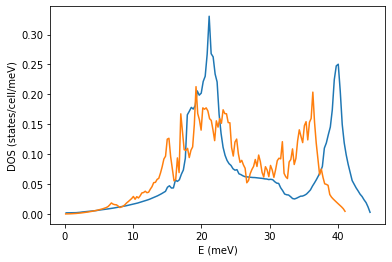

In [39]:
ph_energy_dos_perf=np.loadtxt('02_al_222/total_dos.dat')
ph_energy_dos_vac=np.loadtxt('04_al_222_vac_relaxed_scf/total_dos.dat')

#Density of states per atom for perfect Al
ph_energy_dos_perf = np.array([ph_energy_dos_perf[:,0]*THz_to_meV, 
                            ph_energy_dos_perf[:,1]/(THz_to_meV*4)]).T
ph_energy_dos_perf = ph_energy_dos_perf[np.where(ph_energy_dos_perf[:, 0] > 0)]
ph_energy_dos_perf = ph_energy_dos_perf[np.where(ph_energy_dos_perf[:, 1] > 0)]

#Density of states per atom for vacancy Al
ph_energy_dos_vac = np.array([ph_energy_dos_vac[:,0]*THz_to_meV, 
                           ph_energy_dos_vac[:,1]/(THz_to_meV*31)]).T
ph_energy_dos_vac = ph_energy_dos_vac[np.where(ph_energy_dos_vac[:, 0] > 0)]
ph_energy_dos_vac = ph_energy_dos_vac[np.where(ph_energy_dos_vac[:, 1] > 0)]

plt.plot(*ph_energy_dos_perf.T)
plt.plot(*ph_energy_dos_vac.T)
plt.xlabel("E (meV)")
plt.ylabel("DOS (states/cell/meV)")
plt.show()

In [40]:
# Check integrating the whole DOS gives the number of bands correctly (12)
n_modes_perf = simps(ph_energy_dos_perf.T[1], ph_energy_dos_perf.T[0])
n_modes_vac = simps(ph_energy_dos_vac.T[1], ph_energy_dos_vac.T[0])
print(n_modes_perf, n_modes_vac)

2.997184882528882 2.989730571041088


In [35]:
# zero-point energy estimate (Fph (T=0))
3*25/2

37.5

In [36]:
def phonon_free_energy_atT(energy_dos, T=300):
    assert T > 0, "Error: This function will only work for T>0."
    integrand=[]
    for energy, dos in energy_dos:
        integrand.append(dos*(energy*0.5 + kelvin_to_meV*T*
                              np.log(1-np.exp(-energy/(kelvin_to_meV*T)))))

    F = scipy.integrate.trapz(integrand,  energy_dos[:,0])
    return F

#zpe
print(phonon_free_energy_atT(ph_energy_dos_vac, T=0.01), phonon_free_energy_atT(ph_energy_dos_perf, T=0.01))

36.92228629228953 40.02869214946732


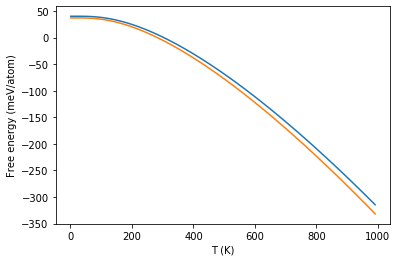

In [21]:
def phonon_free_energy(energy_dos, Tmax=1000):
    assert Tmax>0, "Error: This function will only work for T>0."
    free_energy_temperature = np.array(
        [(t, phonon_free_energy_atT(energy_dos, t)) 
         for t in range(1,Tmax,10)]).T
    return free_energy_temperature


phonon_free_energy_vs_T_perf = phonon_free_energy(ph_energy_dos_perf, Tmax=1000)
phonon_free_energy_vs_T_vac = phonon_free_energy(ph_energy_dos_vac, Tmax=1000)

plt.plot(*phonon_free_energy_vs_T_perf)
plt.plot(*phonon_free_energy_vs_T_vac)
plt.xlabel("T (K)")
plt.ylabel("Free energy (meV/atom)")
plt.show()

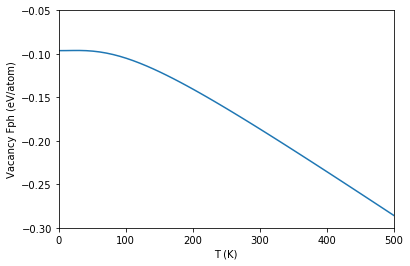

In [56]:
temperature_fph_difference = np.array(
    [phonon_free_energy_vs_T_perf[0,:], 
     n_vac_cell_atoms*phonon_free_energy_vs_T_vac[1,:]/1000 
     - (n_vac_cell_atoms)*phonon_free_energy_vs_T_perf[1,:]/1000])

plt.plot(*temperature_fph_difference)
plt.xlabel("T (K)")
plt.ylabel("Vacancy Fph (eV/atom)")
plt.xlim(0,500)
plt.ylim(-0.3,-0.05)
plt.show()

#### Vacancy formation energy including ph and el terms

In [32]:
temperatre_formation_free_energy_vac = np.array(
    [temperature_fph_difference[0], 
     E0_vac_form + temperature_fph_difference[1] 
     + (t_fel_difference.T)[1]])

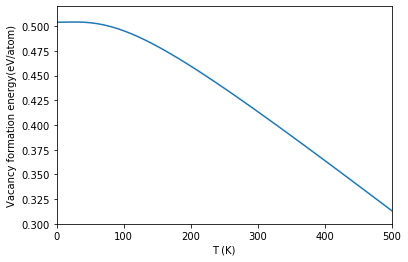

In [50]:
plt.plot(*temperatre_formation_free_energy_vac)
plt.xlabel("T (K)")
plt.ylabel("Vacancy formation energy(eV/atom)")
plt.xlim(0,500)
plt.ylim(0.3,0.52)
plt.show()

### Task
1. Find the electronic contribution to the vacancy formation at the static density of states level of theory, by computing:

$$F^\text{static}_\text{el} = U^\text{static}_\text{el} -TS^\text{static}_\text{el}\,,$$

where $U^\text{static}_\text{el}$ is given by,

$$ U^\text{static}_\text{el} = \int_{-\infty}^{+\infty} g(\varepsilon) f \varepsilon \text{d}\varepsilon - \int_{-\infty}^{0} g(\varepsilon) \varepsilon \text{d}\varepsilon \,, $$

and 

$$S^\text{static}_\text{el}=-k_\text{B}\int_{-\infty}^{+\infty} \, g(\varepsilon) \, (f\text{ln}f+ (1\text{-}f)\text{ln}(1\text{-}f))  \,  \text{d}\varepsilon\,. $$
2. Use $F^\text{static}_\text{el}$ to compute the vacancy formation energy.
